In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation, TimeDistributed, BatchNormalization
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from dataprep import get_vectors, get_data

import tensorflow as tf
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To calculate on GPU
# https://github.com/tensorflow/tensorflow/issues/33721
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [3]:
# CONSTANTS
seed = 42
lr = 0.0001
batch = 32

Get my own dataset

In [5]:
cmt_pos = pd.read_csv('../../datasets/preprocessed data/unstemmed/no_trans_stem_pos.csv')
cmt_neg = pd.read_csv('../../datasets/preprocessed data/unstemmed/no_trans_stem_neg.csv')

In [5]:
X, Y, vocab_size, emdedding_size, vectors = get_data(cmt_pos, cmt_neg, 3)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3, stratify=Y, shuffle=True)
# check if the data is evenly split
import collections
print('Train labels: ', collections.Counter(y_train))
print('Test labels: ', collections.Counter(y_test))

Train labels:  Counter({1: 2206, 0: 2206})
Test labels:  Counter({1: 946, 0: 946})


In [6]:
# Cross validation setup
sk = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True) 

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [8]:
adamOptimizer = Adam(lr=lr)

In [9]:
def plot_history(history_arrs, train, val, xlabel, ylabel, plot_title):
    if len(history_arrs) == 1:
        history = history_arrs[0]
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title(plot_title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    else:
        f, a = plt.subplots(1, len(history_arrs), figsize=(10,5))
        for idx, history in enumerate(history_arrs):
            a[idx].plot(history[train])
            a[idx].plot(history[val])
            title = plot_title + ' ' + str(idx)
            a[idx].set_title(title)
            a[idx].set_xlabel(xlabel)
            a[idx].set_ylabel(ylabel)
            a[idx].legend(['Train', 'Validation'], loc='upper left')
        f.tight_layout()
        plt.show()

In [10]:
def model_1(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

In [11]:
def run_test(model_func, Xtrain, ytrain, X_test, y_test, embedding_layer):
    results = []
    histories = []
    best_model = None
    best_acc = 0
    for train_index, val_index in sk.split(X_train, y_train):
        Xt, Xv = Xtrain[train_index], Xtrain[val_index]
        yt, yv = ytrain[train_index], ytrain[val_index]
        model = model_func(embedding_layer)
        history = model.fit(Xt, yt, validation_data=(Xv, yv), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
        histories.append(history.history)
        loss, acc = model.evaluate(X_test, y_test, verbose=0, batch_size=batch)
        if best_acc < acc:
            best_model = model
        results.append([loss, acc])
    results = np.array(results)
    return results, histories, model

In [12]:
def calculate_metrics(model, X_test, y_test):
    ypred_class = model.predict_classes(X_test, verbose=0)
    ypred_class = ypred_class[:, 0]
    accuracy = accuracy_score(y_test, ypred_class)
    precision = precision_score(y_test, ypred_class)
    recall = recall_score(y_test, ypred_class)
    f1 = f1_score(y_test, ypred_class)
    conf_matrix = confusion_matrix(y_test, ypred_class)
    return accuracy, precision, recall, f1, conf_matrix

In [13]:
def print_conf_matrix(conf_matrix):
    cm = pd.DataFrame(
    conf_matrix, 
    index=['true:positive', 'true:negative'], 
    columns=['pred:positive', 'pred:negative']
    )
    print(cm)

# Model 1

First model cross-validation without pretrained word vectors

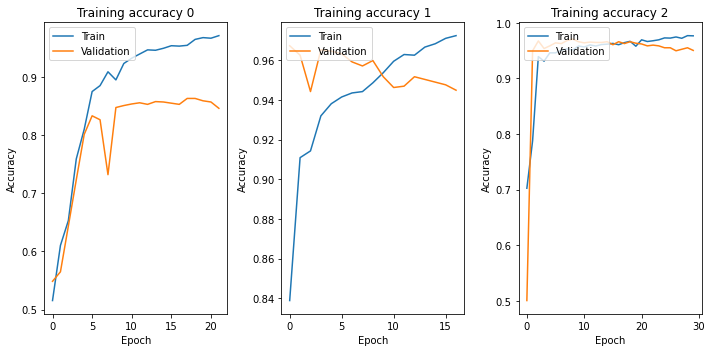

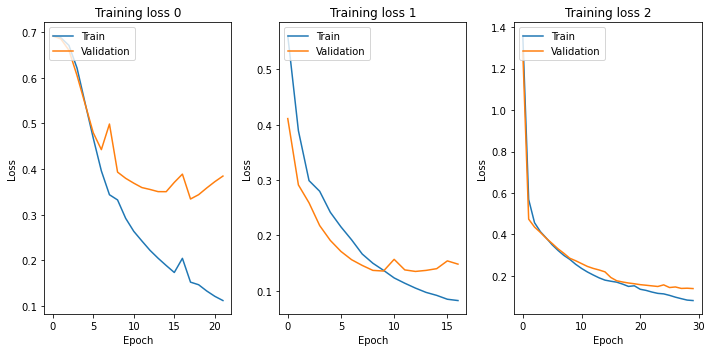

Average model 1 accuracy of cross validation on unseen data: 0.8768
The best perfoming model statistics with class predictions: 
Accuracy: 0.8842
Precision: 0.8822
Recall: 0.8869
F1 score: 0.8846
Confusion matrix:
               pred:positive  pred:negative
true:positive            834            112
true:negative            107            839


In [14]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_1, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 1 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation without pretrained word vectors

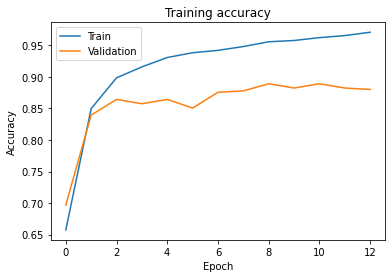

Model statistics with class predictions: 
Accuracy: 0.8827
Precision: 0.8701
Recall: 0.8996
F1 score: 0.8846
Confusion matrix:
               pred:positive  pred:negative
true:positive            819            127
true:negative             95            851


In [15]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_1(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [16]:
# Save the model (weights, architecture)
model.save('../../models/models/lstm-nowv')

INFO:tensorflow:Assets written to: ../../models/models/lstm-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm-nowv\assets


First model cross-validation with pretrained word vectors

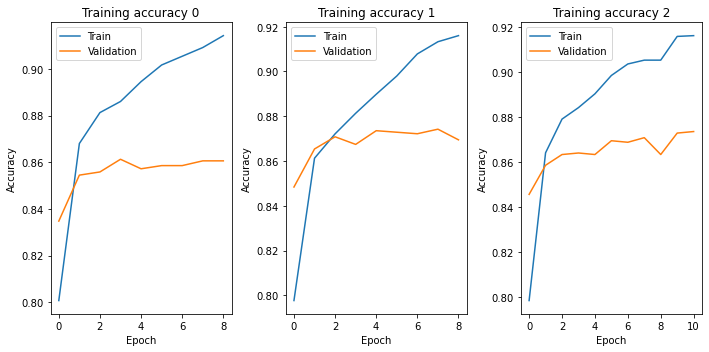

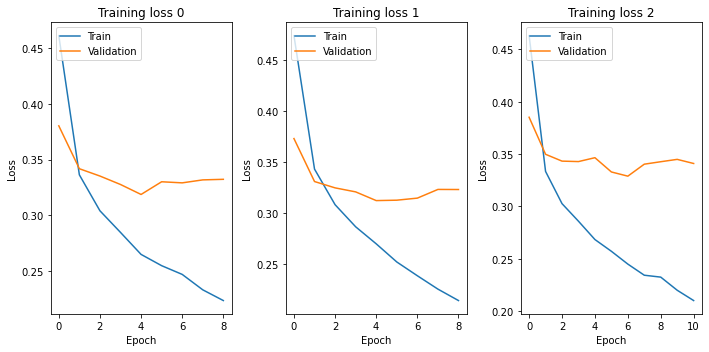

Average model 1 accuracy of cross validation on unseen data: 0.8733
The best perfoming model statistics: 
Accuracy: 0.8763
Precision: 0.8724
Recall: 0.8816
F1 score: 0.8770
Confusion matrix:
               pred:positive  pred:negative
true:positive            824            122
true:negative            112            834


In [17]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
results, histories, model = run_test(model_1, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 1 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation with pretrained word vectors

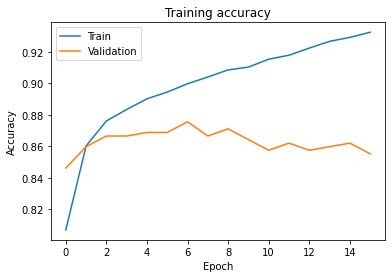

Model statistics with class predictions: 
Accuracy: 0.8742
Precision: 0.8758
Recall: 0.8721
F1 score: 0.8739
Confusion matrix:
               pred:positive  pred:negative
true:positive            829            117
true:negative            121            825


In [18]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
model = model_1(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [19]:
# Save the model (weights, architecture)
model.save('../../models/models/lstm-wv')

INFO:tensorflow:Assets written to: ../../models/models/lstm-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm-wv\assets


# Model 2

In [20]:
def model_2(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dropout(0.1))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

Second model cross-validation without pretrained word vectors

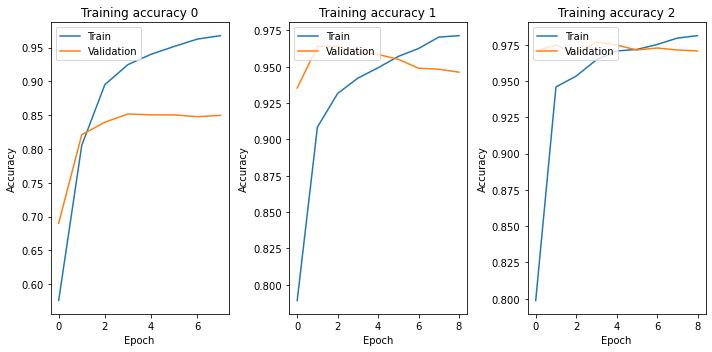

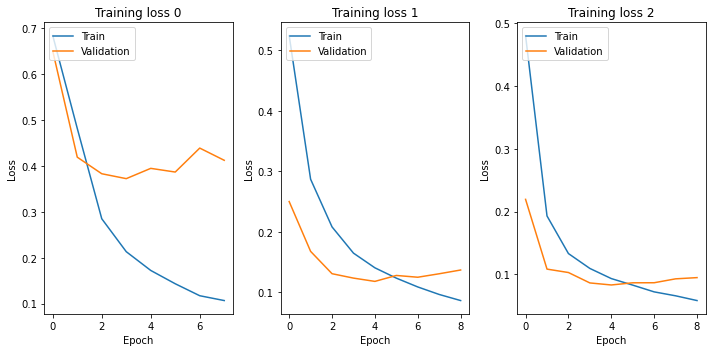

Average model 2 accuracy of cross validation on unseen data: 0.8659
The best perfoming model statistics with class predictions: 
Accuracy: 0.8726
Precision: 0.8615
Recall: 0.8879
F1 score: 0.8745
Confusion matrix:
               pred:positive  pred:negative
true:positive            811            135
true:negative            106            840


In [21]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_2, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 2 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation without pretrained word vectors

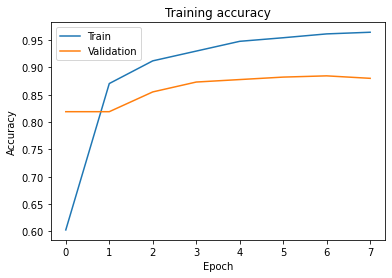

Model statistics with class predictions: 
Accuracy: 0.8742
Precision: 0.8839
Recall: 0.8615
F1 score: 0.8726
Confusion matrix:
               pred:positive  pred:negative
true:positive            839            107
true:negative            131            815


In [22]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_2(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [23]:
# Save best performing model (weights, architecture)
model.save('../../models/models/lstm2-nowv')

INFO:tensorflow:Assets written to: ../../models/models/lstm2-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm2-nowv\assets


Second model cross-validation with pretrained word vectors

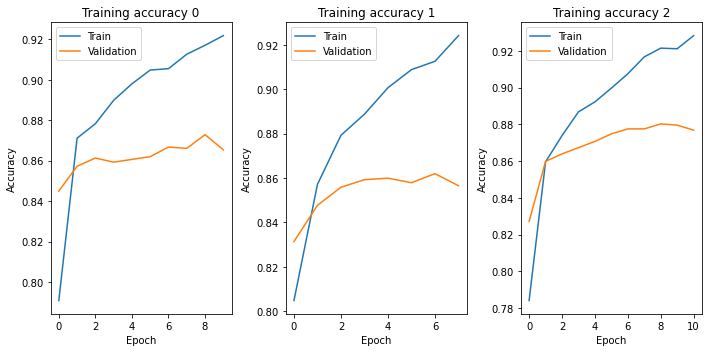

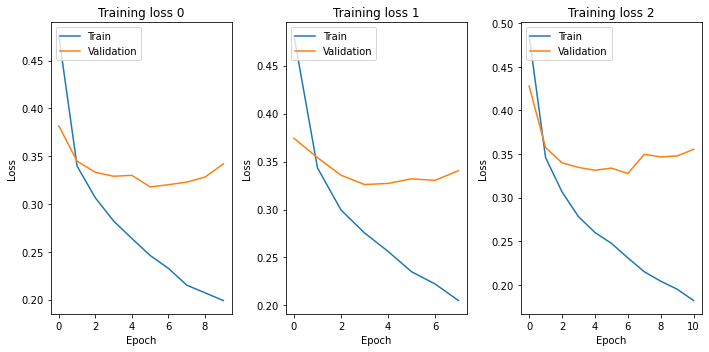

Average model 2 accuracy of cross validation on unseen data: 0.8719
The best perfoming model statistics: 
Accuracy: 0.8710
Precision: 0.8596
Recall: 0.8869
F1 score: 0.8730
Confusion matrix:
               pred:positive  pred:negative
true:positive            809            137
true:negative            107            839


In [24]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
results, histories, model = run_test(model_2, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 2 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation with pretrained word vectors

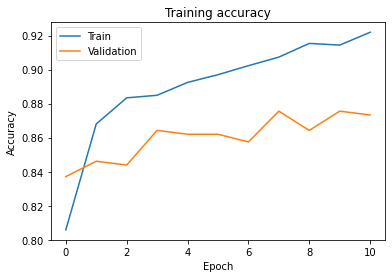

Model statistics with class predictions: 
Accuracy: 0.8832
Precision: 0.8695
Recall: 0.9017
F1 score: 0.8853
Confusion matrix:
               pred:positive  pred:negative
true:positive            818            128
true:negative             93            853


In [25]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
model = model_2(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [26]:
model.save('../../models/models/lstm2-wv')

INFO:tensorflow:Assets written to: ../../models/models/lstm2-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm2-wv\assets


# Model architecture tests on IMDB dataset

In [30]:
# IMDB dataset
from keras.datasets import imdb

In [31]:
word_count = 5000
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=word_count)
max_length = 500
X_train_imdb = sequence.pad_sequences(X_train_imdb, maxlen=max_length)
X_test_imdb = sequence.pad_sequences(X_test_imdb, maxlen=max_length)

## Model 1

First model cross-validation

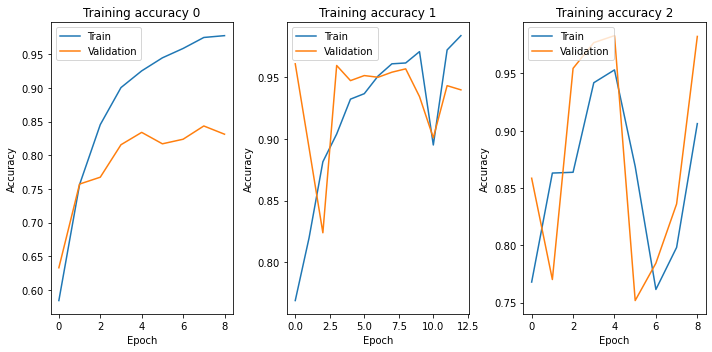

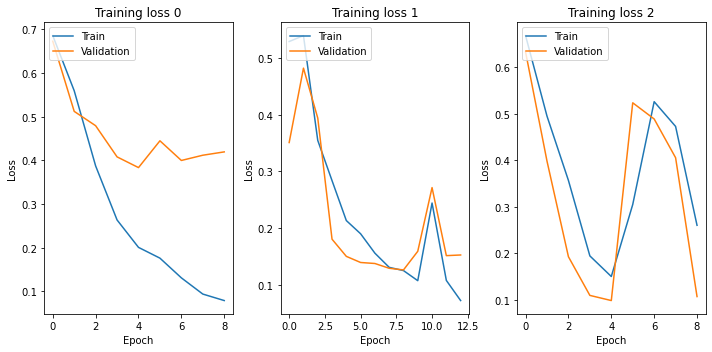

Average model 1 accuracy of cross validation on unseen IMDB data: 0.8384
The best perfoming model statistics: 
Accuracy: 0.8441
Precision: 0.8669
Recall: 0.8131
F1 score: 0.8391
Confusion matrix:
               pred:positive  pred:negative
true:positive          10939           1561
true:negative           2336          10164


In [32]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
results, histories, model = run_test(model_1, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Average model 1 accuracy of cross validation on unseen IMDB data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation

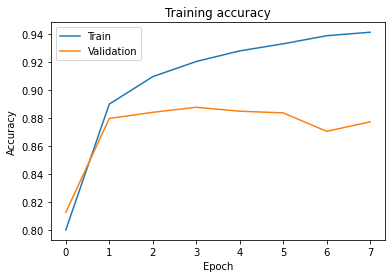

Model statistics with class predictions: 
Accuracy: 0.8758
Precision: 0.8950
Recall: 0.8515
F1 score: 0.8727
Confusion matrix:
               pred:positive  pred:negative
true:positive          11251           1249
true:negative           1856          10644


In [33]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_1(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model cross-validation

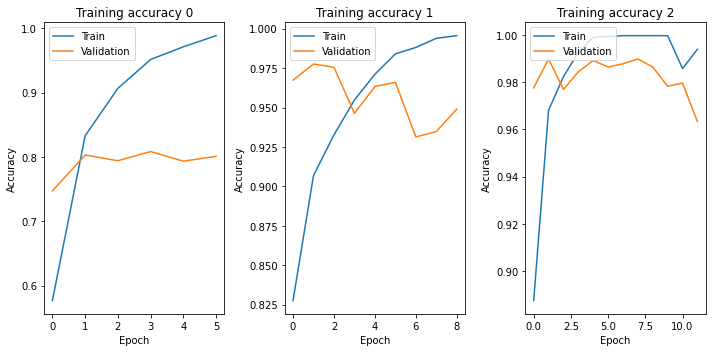

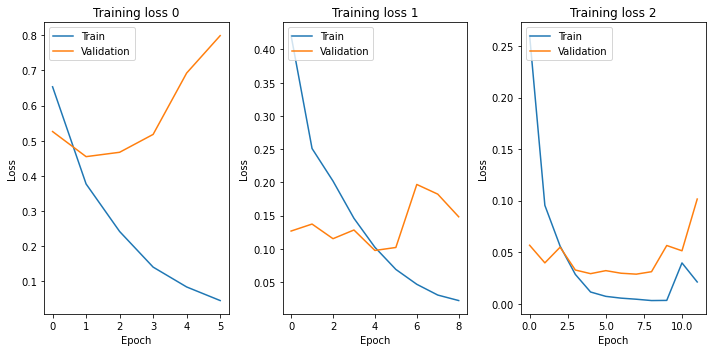

Average model 2 accuracy of cross validation on unseen IMDB data: 0.8026
The best perfoming model statistics: 
Accuracy: 0.7974
Precision: 0.7778
Recall: 0.8325
F1 score: 0.8042
Confusion matrix:
               pred:positive  pred:negative
true:positive           9528           2972
true:negative           2094          10406


In [34]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
results, histories, model = run_test(model_2, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Average model 2 accuracy of cross validation on unseen IMDB data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation

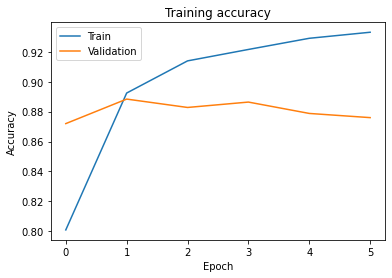

Model 2 statistics with class predictions: 
Accuracy: 0.8736
Precision: 0.8770
Recall: 0.8690
F1 score: 0.8730
Confusion matrix:
               pred:positive  pred:negative
true:positive          10976           1524
true:negative           1637          10863


In [35]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_2(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model 2 statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)